In [20]:
import pprint
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline

# Comparison of Bayesian Optimization Frameworks

In this notebook we are going to compare different bayesian optimization libraries against each other. To compare our results we will use [Kaggle's Mobile Price Classification](https://www.kaggle.com/datasets/iabhishekofficial/mobile-price-classification?datasetId=11167&sortBy=voteCount) dataset. We performed a short EDA on this dataset in [notebooks/eda__mobile_price_classification.ipynb](https://github.com/PeeteKeesel/bayes-opt-battle/blob/main/notebooks/eda__mobile_price_classification.ipynb).  

## Global Settings

In [4]:
RANDOM_SEED = 42
DATASET_FOLDER = '../../datasets/mobile_price_classification'

In [5]:
train = pd.read_csv(f'{DATASET_FOLDER}/train.csv')
test = pd.read_csv(f'{DATASET_FOLDER}/test.csv')
print(f"""
Shapes
======
    train: {train.shape}
    test : {test.shape}      
""")
train.head(3)


Shapes
    train: (2000, 21)
    test : (1000, 21)      



,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2


In [6]:
TARGET = 'price_range'
FEATURES = list(set(train.columns).difference({TARGET}))

In [7]:

def predict_and_summarize(X_train_scaled,
                          X_test_scaled, 
                          y_train, 
                          y_test,
                          clf,
                          model_type):

    y_pred_train = clf.predict(X_train_scaled)
    train_acc = accuracy_score(y_train, y_pred_train)
    train_prec = precision_score(y_train, y_pred_train, average='macro', zero_division=0)
    train_rec = recall_score(y_train, y_pred_train, average='macro', zero_division=0)
    train_f1 = f1_score(y_train, y_pred_train, average='macro', zero_division=0)

    y_pred = clf.predict(X_test_scaled)
    test_acc = accuracy_score(y_test, y_pred)
    test_prec = precision_score(y_test, y_pred, average='macro', zero_division=0)
    test_rec = recall_score(y_test, y_pred, average='macro', zero_division=0)
    test_f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)

    print(f"""
    Performance Results : {model_type} 
    ========================================
                    {'Train':<10}{'Test':<10}
        Accuracy  : {train_acc:<10.4f}{test_acc:<10.4f}
        Precision : {train_prec:<10.4f}{test_prec:<10.4f}
        Recall    : {train_rec:<10.4f}{test_rec:<10.4f}
        F1-Score  : {train_f1:<10.4f}{test_f1:<10.4f}
    """)

    return {'y_pred_train': y_pred_train, 'y_pred_test': y_pred}

## Dataset Preparation

In [8]:
X_train, X_test, y_train, y_test = train_test_split(train[FEATURES],
                                                    train[TARGET], 
                                                    test_size=0.3, 
                                                    random_state=RANDOM_SEED,
                                                    stratify=train[TARGET])

In [9]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Bayesian Hyperparameter Optimization

Now we will tune the models hyperparameters using different libraries provided by Python.

We will use `Precision` as our optimization metric.

In [14]:
X_tra, X_val, y_tra, y_val = train_test_split(X_train,
                                              y_train, 
                                              test_size=0.2, 
                                              random_state=RANDOM_SEED,
                                              stratify=y_train)
print(f"""
Shapes
======
    train : {X_tra.shape}
    val   : {X_val.shape}
    test  : {X_test.shape}
""")


Shapes
    train : (1120, 20)
    val   : (280, 20)
    test  : (600, 20)



## Optuna

In [49]:
N_TRIALS = 300

In [58]:
accuracies_train, precisions_train, recalls_train, f1s_train = [], [], [], []
accuracies_val, precisions_val, recalls_val, f1s_val = [], [], [], []
accuracies_test, precisions_test, recalls_test, f1s_test = [], [], [], []

def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 2, 15)
    min_samples_split = trial.suggest_float('min_samples_split', 0.1, 1.0)
    min_samples_leaf = trial.suggest_float('min_samples_leaf', 0.1, 1.0)
    
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            random_state=RANDOM_SEED
        ))
    ])
        
    pipeline.fit(X_tra, y_tra)

    y_pred_train = pipeline.predict(X_tra)
    y_pred_val = pipeline.predict(X_val)
    y_test_pred = pipeline.named_steps['classifier'].predict(X_test_scaled)
    
    prec_train = precision_score(y_tra, y_pred_train, average='macro', zero_division=0)
    prec_val = precision_score(y_val, y_pred_val, average='macro', zero_division=0)
    prec_test = precision_score(y_test, y_test_pred, average='macro', zero_division=0)

    precisions_train.append(prec_train)
    precisions_val.append(prec_val)
    precisions_test.append(prec_test)

    return prec_val

In [59]:
start_time = time.time()

# Creating a study and running Optuna optimization.
study = optuna.create_study(study_name='my_optuna_study',
                            direction='maximize')
study.optimize(objective, n_trials=N_TRIALS)

elapsed_time = time.time() - start_time
elapsed_minutes, elapsed_seconds = int(elapsed_time // 60), int(elapsed_time % 60)

[I 2023-08-12 18:25:20,502] A new study created in memory with name: my_optuna_study
[I 2023-08-12 18:25:20,625] Trial 0 finished with value: 0.0625 and parameters: {'n_estimators': 54, 'max_depth': 8, 'min_samples_split': 0.31830644927934054, 'min_samples_leaf': 0.7013190248665959}. Best is trial 0 with value: 0.0625.
[I 2023-08-12 18:25:20,898] Trial 1 finished with value: 0.0625 and parameters: {'n_estimators': 158, 'max_depth': 4, 'min_samples_split': 0.6695505406276745, 'min_samples_leaf': 0.4920296411200268}. Best is trial 0 with value: 0.0625.
[I 2023-08-12 18:25:21,299] Trial 2 finished with value: 0.0625 and parameters: {'n_estimators': 272, 'max_depth': 3, 'min_samples_split': 0.5660230247866214, 'min_samples_leaf': 0.7501764753831094}. Best is trial 0 with value: 0.0625.
[I 2023-08-12 18:25:21,485] Trial 3 finished with value: 0.0625 and parameters: {'n_estimators': 134, 'max_depth': 15, 'min_samples_split': 0.21466637245828524, 'min_samples_leaf': 0.9680475984475518}. Best 

In [60]:
# The searched optimal parameters.
best_params = study.best_params

# Create the pipeline with the searched optimal parameters.
best_rfc = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(
        n_estimators=best_params['n_estimators'],
        max_depth=best_params['max_depth'],
        min_samples_split=best_params['min_samples_split'],
        min_samples_leaf=best_params['min_samples_leaf'],
        random_state=RANDOM_SEED,
    ))
])

# Train the final model on the searched optimal parameters.
best_rfc.fit(X_train_scaled, y_train)

# Train metrics.
y_train_pred = best_rfc.predict(X_train_scaled)
train_acc = accuracy_score(y_train, y_train_pred)
train_prec = precision_score(y_train, y_train_pred, average='macro', zero_division=0)
train_rec = recall_score(y_train, y_train_pred, average='macro', zero_division=0)
train_f1 = f1_score(y_train, y_train_pred, average='macro', zero_division=0)

# Test metrics.
y_test_pred = best_rfc.predict(X_test_scaled)
test_acc = accuracy_score(y_test, y_test_pred)
test_prec = precision_score(y_test, y_test_pred, average='macro', zero_division=0)
test_rec = recall_score(y_test, y_test_pred, average='macro', zero_division=0)
test_f1 = f1_score(y_test, y_test_pred, average='macro', zero_division=0)

print(f"""
Optuna Results
==============
                {'Train':<10}{'Test':<10}
    Accuracy  : {train_acc:<10.4f}{test_acc:<10.4f}
    Precision : {train_prec:<10.4f}{test_prec:<10.4f}
    Recall    : {train_rec:<10.4f}{test_rec:<10.4f}
    F1-Score  : {train_f1:<10.4f}{test_f1:<10.4f}

Tuning time: {elapsed_minutes} min {elapsed_seconds} sec

Best parameters:
""")
pp = pprint.PrettyPrinter()
pp.pprint(best_params)


Optuna Results
                Train     Test      
    Accuracy  : 0.8129    0.7817    
    Precision : 0.8117    0.7747    
    Recall    : 0.8129    0.7817    
    F1-Score  : 0.8029    0.7661    

Tuning time: 1 min 9 sec

Best parameters:

{'max_depth': 15,
 'min_samples_leaf': 0.10006906065511395,
 'min_samples_split': 0.1714605883298128,
 'n_estimators': 95}


#### Plots

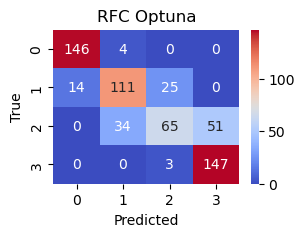

In [66]:
cm = confusion_matrix(y_test, y_test_pred)
class_labels = np.unique(y_test)

plt.figure(figsize=(3, 2))
sns.heatmap(cm, 
            annot=True, 
            cmap='coolwarm', 
            fmt='d', 
            xticklabels=class_labels, 
            yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('RFC Optuna')

plt.savefig('../../imgs/rfc_cm_optuna.png', dpi=300, bbox_inches='tight')

plt.show()

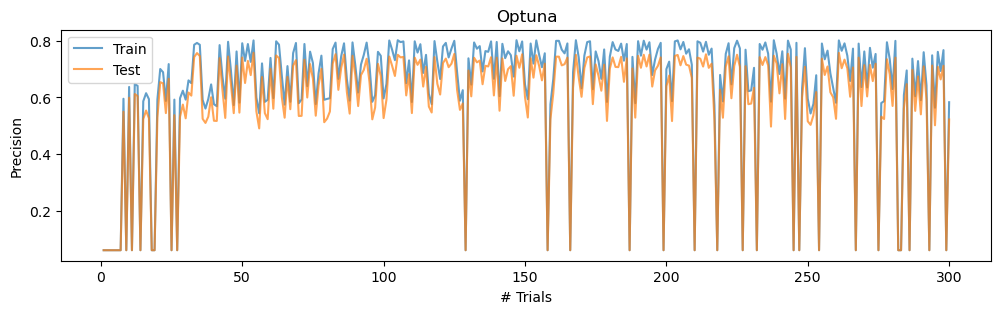

In [64]:
plt.figure(figsize=(12, 3))

plt.plot(np.arange(1, N_TRIALS+1, 1), precisions_train, label='Train', alpha=0.7, color='C0');
plt.plot(np.arange(1, N_TRIALS+1, 1), precisions_test, label='Test', alpha=0.7, color='C1');

plt.xlabel("# Trials");
plt.ylabel("Precision");
plt.legend();

plt.title("Optuna");
plt.show();